 # Notebook 1: Data Exploration and Cleaning

 ## Purpose
 - Load and explore the article dataset (54k articles)
 - Load and explore calendar events dataset
 - Perform data quality checks
 - Clean text with stop words removal
 - Handle missing values and duplicates
 - Save cleaned data

In [2]:
# Import required libraries
import pandas as pd
import numpy as np
import re
import warnings
from pathlib import Path
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import nltk
from nltk.corpus import stopwords

warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', 100)

plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')

print("Libraries imported successfully")

Libraries imported successfully


 ## 1. Setup Paths and Load Data

In [3]:
# Define paths
BASE_DIR = Path('..')
RAW_DATA_DIR = BASE_DIR / 'data' / 'raw'
PROCESSED_DATA_DIR = BASE_DIR / 'data' / 'processed'

ARTICLES_FILE = RAW_DATA_DIR / 'test.articles.csv'
CALENDAR_FILE = RAW_DATA_DIR / 'india_calendar_events_1995_2025.csv'

ARTICLES_CLEANED = PROCESSED_DATA_DIR / 'articles_cleaned.csv'
CALENDAR_CLEANED = PROCESSED_DATA_DIR / 'calendar_events_cleaned.csv'

PROCESSED_DATA_DIR.mkdir(parents=True, exist_ok=True)

print(f"Paths configured")
print(f"  Articles file exists: {ARTICLES_FILE.exists()}")
print(f"  Calendar file exists: {CALENDAR_FILE.exists()}")

Paths configured
  Articles file exists: True
  Calendar file exists: True


In [4]:
# Load articles dataset
print("Loading articles dataset...")
df_articles = pd.read_csv(
    ARTICLES_FILE,
    # escapechar='\\',
    # quotechar='"',
    # encoding='utf-8',
    low_memory=False
)

print(f"Loaded {len(df_articles):,} articles")
print(f"Shape: {df_articles.shape}")
print(f"Columns: {list(df_articles.columns)}")

Loading articles dataset...
Loaded 54,545 articles
Shape: (54545, 24)
Columns: ['_id', 'success', 'url', 'title', 'author', 'published_date', 'modified_date', 'section', 'tags', 'article_text', 'word_count', 'error', 'media_name', 'scrape_date', 'scraped_at', 'scrape_page', 'article_id', 'api_headline', 'api_summary', 'state', 'city', 'archive_date', 'pub_date', 'year']


In [5]:
# Display sample
df_articles.head(2)

,_id,success,url,title,author,published_date,modified_date,section,tags,article_text,word_count,error,media_name,scrape_date,scraped_at,scrape_page,article_id,api_headline,api_summary,state,city,archive_date,pub_date,year
0,692471819877309fb288c6c7,True,https://indianexpress.com/article/technology/mobile-tabs/amazon-great-indian-festival-sale-top-d...,"Amazon Great Indian Festival sale: Top deals on OnePlus 6, Samsung Galaxy S9, Vivo V9 Pro and more",":Tech DeskNew Delhi |Updated: October 8, 2018 10:27 PM IST7 min read",2018-10-08,2018-10-08T22:27:48+05:30,NaN,NaN,Amazon Great Indian Festival sale:Amazon’s upcoming Great Indian Festival sale will kick off on ...,896,NaN,THE INDIAN EXPRESS,2018-10-08,2025-11-24T20:23:53.373098,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2018-10-08,2018.0
1,6923412c9877309fb28732a4,True,https://indianexpress.com/article/news-archive/congs-wasteland/,Cong’s wasteland,"PRANNOY ROY, YOGENDRA YADAV, I P BAJPAI, NAMRATA GUPTA, SABA SIDDIQUI And DORAB SOPARIWALANew De...",2004-03-28,2004-03-28,NaN,NaN,"A mid-March opinion poll, jointly commissioned byThe Indian Expressand NDTV and conducted by A C...",1067,NaN,THE INDIAN EXPRESS,2004-03-28,2025-11-23T22:45:24.777408,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2004-03-28,2004.0


In [6]:
# Load calendar dataset
print("Loading calendar events...")
df_calendar = pd.read_csv(CALENDAR_FILE)

print(f"Loaded {len(df_calendar):,} calendar entries")
print(f"Shape: {df_calendar.shape}")

Loading calendar events...
Loaded 11,323 calendar entries
Shape: (11323, 11)


In [7]:
df_calendar.head(2)

,Date,Day,Is_Holiday,Holiday_Name,Holiday_Category,Events_Count,Event_Good_Count,Event_Bad_Count,Event_Sentiment,Event_Texts,Event_Links
0,1995-01-01,Sunday,False,NaN,NaN,3,0,0,neutral,The World Trade Organization comes into being. || The Draupner wave in the North Sea in Norway i...,https://en.wikipedia.org/wiki/World_Trade_Organization || https://en.wikipedia.org/wiki/Draupner...
1,1995-01-02,Monday,False,NaN,NaN,0,0,0,neutral,NaN,NaN


 ## 2. Data Quality Assessment

In [8]:
# Articles quality check
print("=== ARTICLES DATASET QUALITY REPORT ===\n")
print(f"Total rows: {len(df_articles):,}")
print(f"Total columns: {len(df_articles.columns)}")
print(f"Memory usage: {df_articles.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

# Missing values
missing = df_articles.isnull().sum()
missing_pct = (missing / len(df_articles) * 100).round(2)
missing_df = pd.DataFrame({
    'Missing Count': missing,
    'Percentage': missing_pct
})
missing_df = missing_df[missing_df['Missing Count'] > 0].sort_values('Missing Count', ascending=False)

print("\n--- Missing Values ---")
print(missing_df)

=== ARTICLES DATASET QUALITY REPORT ===

Total rows: 54,545
Total columns: 24
Memory usage: 284.08 MB

--- Missing Values ---
                Missing Count  Percentage
scrape_page             54545      100.00
api_headline            54545      100.00
error                   54545      100.00
state                   54545      100.00
api_summary             54545      100.00
archive_date            50001       91.67
city                    50001       91.67
article_id              50000       91.67
section                 48121       88.22
tags                    41924       76.86
modified_date            8286       15.19
author                   7667       14.06
scraped_at               4545        8.33
scrape_date              4545        8.33
pub_date                 4545        8.33
year                     4545        8.33
article_text              121        0.22
published_date              1        0.00


In [9]:
# Check duplicates
duplicate_urls = df_articles['url'].duplicated().sum()
duplicate_titles = df_articles['title'].duplicated().sum()
duplicate_full = df_articles.duplicated().sum()

print("\n--- Duplicates ---")
print(f"Duplicate URLs: {duplicate_urls:,}")
print(f"Duplicate titles: {duplicate_titles:,}")
print(f"Fully duplicate rows: {duplicate_full:,}")


--- Duplicates ---
Duplicate URLs: 0
Duplicate titles: 605
Fully duplicate rows: 0


In [10]:
# Text statistics
df_articles['text_length'] = df_articles['article_text'].fillna('').str.len()
df_articles['word_count_calc'] = df_articles['article_text'].fillna('').str.split().str.len()

print("\n--- Article Text Statistics ---")
print(f"Min text length: {df_articles['text_length'].min():,} characters")
print(f"Max text length: {df_articles['text_length'].max():,} characters")
print(f"Mean text length: {df_articles['text_length'].mean():.0f} characters")
print(f"Median text length: {df_articles['text_length'].median():.0f} characters")
print(f"\nMin word count: {df_articles['word_count_calc'].min():,} words")
print(f"Max word count: {df_articles['word_count_calc'].max():,} words")
print(f"Mean word count: {df_articles['word_count_calc'].mean():.0f} words")
print(f"Median word count: {df_articles['word_count_calc'].median():.0f} words")


--- Article Text Statistics ---
Min text length: 0 characters
Max text length: 71,753 characters
Mean text length: 2497 characters
Median text length: 2066 characters

Min word count: 0 words
Max word count: 10,819 words
Mean word count: 400 words
Median word count: 329 words


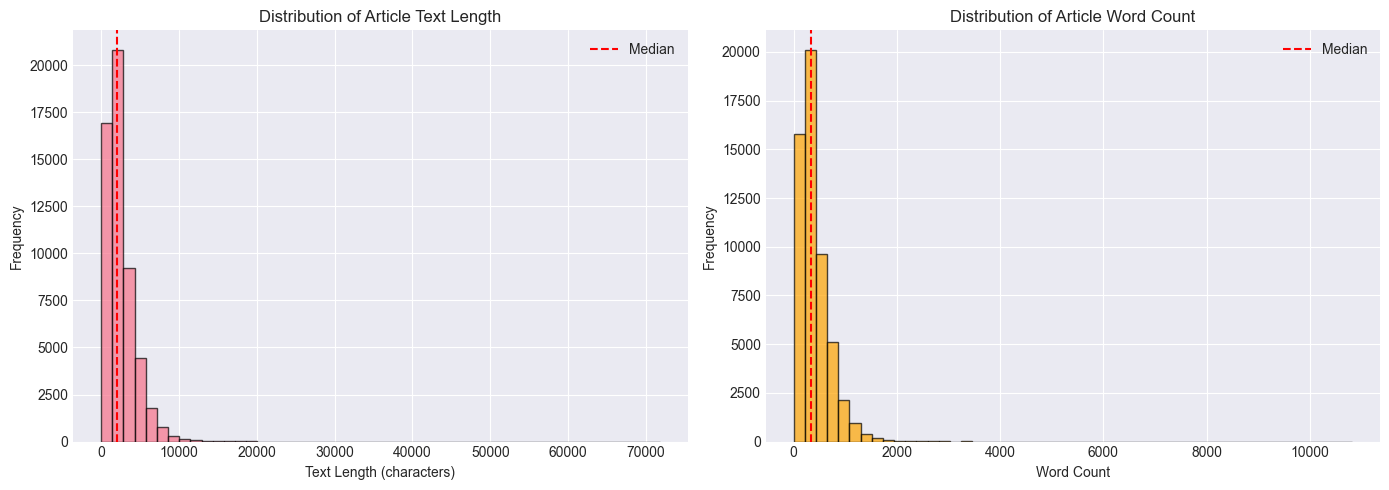

In [11]:
# Visualize distributions
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].hist(df_articles['text_length'], bins=50, edgecolor='black', alpha=0.7)
axes[0].set_xlabel('Text Length (characters)')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Distribution of Article Text Length')
axes[0].axvline(df_articles['text_length'].median(), color='red', linestyle='--', label='Median')
axes[0].legend()

axes[1].hist(df_articles['word_count_calc'], bins=50, edgecolor='black', alpha=0.7, color='orange')
axes[1].set_xlabel('Word Count')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Distribution of Article Word Count')
axes[1].axvline(df_articles['word_count_calc'].median(), color='red', linestyle='--', label='Median')
axes[1].legend()

plt.tight_layout()
plt.show()

Key Insights: Text length & word count distributions

1) The two histograms confirm that both text length and word count are heavily right‑skewed: most articles cluster around moderate lengths, while a minority extend into very long, long‑tail territory.

2) The red median lines highlight the central tendency, showing that half the articles are shorter than roughly the 2k‑character / 300–400‑word region, with a long tail above it.

In [12]:
# Check short/empty articles
empty_articles = (df_articles['article_text'].isna()) | (df_articles['article_text'] == '')
short_articles = df_articles['word_count_calc'] < 50

print("\n--- Short/Empty Articles ---")
print(f"Empty articles: {empty_articles.sum():,}")
print(f"Articles with < 50 words: {short_articles.sum():,}")
print(f"Articles with < 100 words: {(df_articles['word_count_calc'] < 100).sum():,}")


--- Short/Empty Articles ---
Empty articles: 121
Articles with < 50 words: 3,656
Articles with < 100 words: 5,189


 ## 3. Date Parsing

In [13]:
# pandas can handle mixed ISO formats automatically
df_articles['published_date_parsed'] = pd.to_datetime(
    df_articles['published_date'],
    errors='coerce',
    utc=False  # Keep timezone information
)

# Check if parsing was successful
success_count = df_articles['published_date_parsed'].notna().sum()
print(f"Successfully parsed: {success_count} out of {len(df_articles)} dates")

# Extract date component
df_articles['date_only'] = df_articles['published_date_parsed'].dt.date

# Count failures
failed_dates = df_articles['published_date_parsed'].isna().sum()
print(f"Failed to parse: {failed_dates} dates")

Successfully parsed: 54544 out of 54545 dates
Failed to parse: 1 dates


In [14]:
# Extract date components
df_articles['publication_date'] = df_articles['published_date_parsed'].dt.date
df_articles['publication_year'] = df_articles['published_date_parsed'].dt.year
df_articles['publication_month'] = df_articles['published_date_parsed'].dt.month
df_articles['publication_day'] = df_articles['published_date_parsed'].dt.day

print("\n--- Publication Date Range ---")
print(f"Earliest: {df_articles['published_date_parsed'].min()}")
print(f"Latest: {df_articles['published_date_parsed'].max()}")
print(f"\nArticles by year:")
print(df_articles['publication_year'].value_counts().sort_index())


--- Publication Date Range ---
Earliest: 1998-01-01 00:00:00
Latest: 2025-11-30 00:00:00

Articles by year:
publication_year
1998.0    1663
1999.0    1658
2000.0    1640
2001.0     778
2002.0    1615
2003.0    1648
2004.0    1681
2005.0    1661
2006.0    1642
2007.0    1660
2008.0    1639
2009.0    1634
2010.0    1626
2011.0    1630
2012.0    1616
2013.0    1605
2014.0    1668
2015.0    1643
2016.0    1648
2017.0    1662
2018.0    1638
2019.0    1663
2020.0    1693
2021.0    1664
2022.0    2373
2023.0    2828
2024.0    5586
2025.0    5082
Name: count, dtype: int64


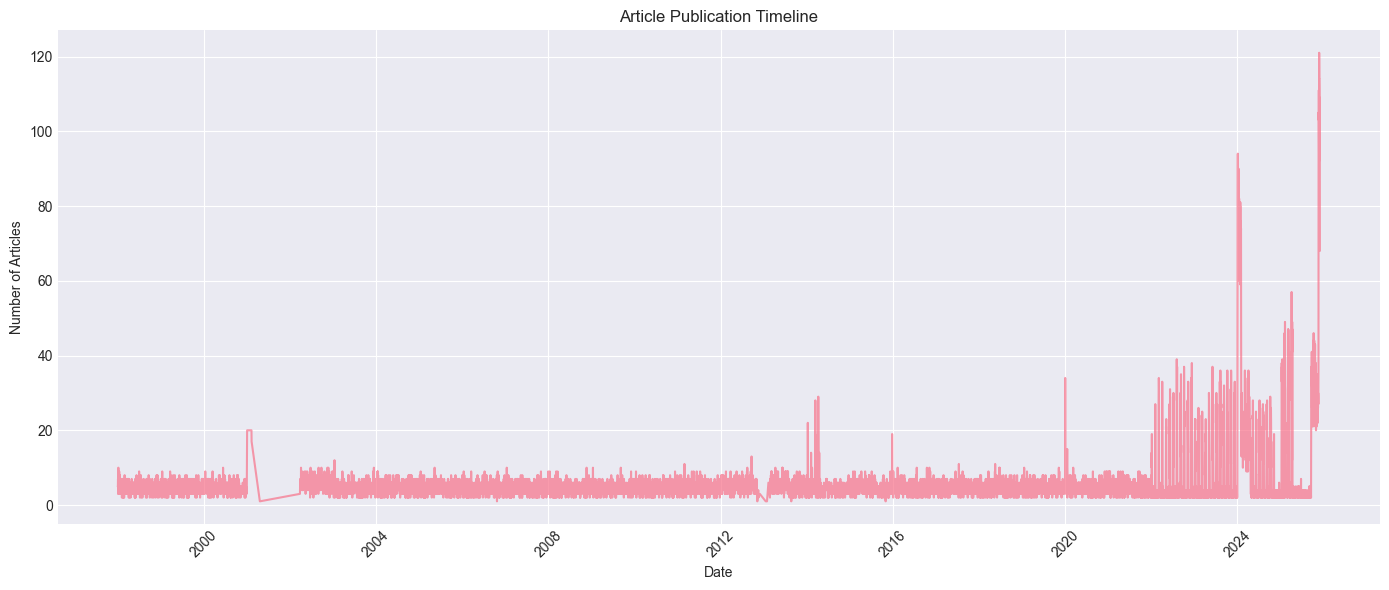

In [15]:
# Visualize publication timeline
fig, ax = plt.subplots(figsize=(14, 6))
df_articles['publication_date'].value_counts().sort_index().plot(ax=ax, alpha=0.7)
ax.set_xlabel('Date')
ax.set_ylabel('Number of Articles')
ax.set_title('Article Publication Timeline')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

#### Key Insights:  Article publication timeline (line plot)

1. The line plot shows daily article counts over nearly three decades, with noticeable fluctuations and a clear increase in publishing frequency in more recent years.

2. The dense clustering of points toward the right side of the timeline indicates that newer years contribute a disproportionately large share of articles, which can introduce recency bias in downstream analyses.

In [16]:
# Calendar date range
df_calendar['Date'] = pd.to_datetime(df_calendar['Date'])
print("\n--- Calendar Date Range ---")
print(f"Start: {df_calendar['Date'].min()}")
print(f"End: {df_calendar['Date'].max()}")
print(f"Total days: {(df_calendar['Date'].max() - df_calendar['Date'].min()).days:,}")


--- Calendar Date Range ---
Start: 1995-01-01 00:00:00
End: 2025-12-31 00:00:00
Total days: 11,322


In [17]:
# Holiday statistics
holidays = df_calendar['Is_Holiday'] == True
print("\n--- Holiday Statistics ---")
print(f"Total holidays: {holidays.sum():,}")
print(f"Percentage: {(holidays.sum() / len(df_calendar) * 100):.2f}%")

if 'Holiday_Category' in df_calendar.columns:
    print("\nHoliday categories:")
    print(df_calendar[holidays]['Holiday_Category'].value_counts())


--- Holiday Statistics ---
Total holidays: 450
Percentage: 3.97%

Holiday categories:
Holiday_Category
general      194
muslim        96
hindu         75
christian     60
sikh          25
Name: count, dtype: int64


 ## 4. Text Cleaning with Stop Words

In [18]:
# Download NLTK stop words if needed
try:
    stopwords.words('english')
except LookupError:
    print("Downloading NLTK stopwords...")
    nltk.download('stopwords', quiet=True)

# Load English stop words
stop_words = set(stopwords.words('english'))

# Add Indian context-specific stop words
indian_stop_words = {
    'said', 'told', 'also', 'including', 'according', 'however', 'meanwhile',
    'india', 'indian', 'delhi', 'mumbai', 'chennai', 'kolkata', 'bangalore',
    'pm', 'minister', 'government', 'chief', 'party', 'state', 'said'
}
stop_words.update(indian_stop_words)

print(f"Loaded {len(stop_words)} stop words")

Loaded 218 stop words


In [19]:
def clean_text(text):
    """Clean text with stop words removal"""
    if pd.isna(text) or text == '':
        return ''

    # Lowercase
    text = text.lower()

    # Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text)

    # Remove email addresses
    text = re.sub(r'\S+@\S+', '', text)

    # Remove special characters but keep spaces
    text = re.sub(r'[^a-z\s]', ' ', text)

    # Remove extra whitespace
    text = re.sub(r'\s+', ' ', text).strip()

    # Remove stop words
    words = text.split()
    words = [word for word in words if word not in stop_words and len(word) > 2]

    return ' '.join(words)


# Test the function
sample_text = df_articles['article_text'].iloc[0]
print("Original (first 200 chars):")
print(sample_text[:200])
print("\nCleaned:")
print(clean_text(sample_text)[:200])

Original (first 200 chars):
Amazon Great Indian Festival sale:Amazon’s upcoming Great Indian Festival sale will kick off on October 10 and continue till October 15. During the sale, the e-retailer will provide deals and discount

Cleaned:
amazon great festival sale amazon upcoming great festival sale kick october continue till october sale retailer provide deals discounts leading smartphone brands consumers avail per cent discounts pur


In [20]:
# Apply cleaning to all articles (this may take a while)
print("\nCleaning all articles...")
print("This may take several minutes for 320K articles...")

# Clean in chunks to show progress
chunk_size = 10000
total_chunks = len(df_articles) // chunk_size + 1

cleaned_texts = []
for i in range(0, len(df_articles), chunk_size):
    chunk = df_articles['article_text'].iloc[i:i + chunk_size]
    cleaned_chunk = chunk.apply(clean_text)
    cleaned_texts.extend(cleaned_chunk)

    chunk_num = i // chunk_size + 1
    print(f"  Processed chunk {chunk_num}/{total_chunks} ({i + chunk_size:,}/{len(df_articles):,} articles)")

df_articles['article_text_cleaned'] = cleaned_texts
print("Text cleaning complete")


Cleaning all articles...
This may take several minutes for 320K articles...
  Processed chunk 1/6 (10,000/54,545 articles)
  Processed chunk 2/6 (20,000/54,545 articles)
  Processed chunk 3/6 (30,000/54,545 articles)
  Processed chunk 4/6 (40,000/54,545 articles)
  Processed chunk 5/6 (50,000/54,545 articles)
  Processed chunk 6/6 (60,000/54,545 articles)
Text cleaning complete



--- Cleaning Impact ---
Average text length reduction: 35.5%
Average word count reduction: 45.1%


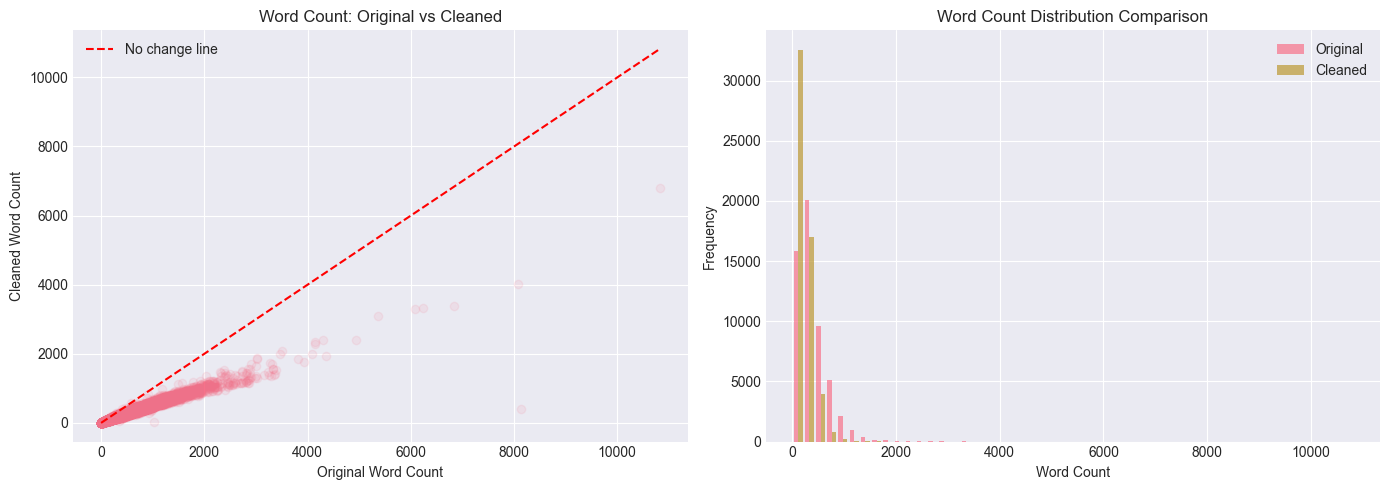

In [21]:
# Compare lengths before/after cleaning
df_articles['cleaned_length'] = df_articles['article_text_cleaned'].str.len()
df_articles['cleaned_word_count'] = df_articles['article_text_cleaned'].str.split().str.len()

print("\n--- Cleaning Impact ---")
print(f"Average text length reduction: {(1 - df_articles['cleaned_length'].mean() / df_articles['text_length'].mean()) * 100:.1f}%")
print(f"Average word count reduction: {(1 - df_articles['cleaned_word_count'].mean() / df_articles['word_count_calc'].mean()) * 100:.1f}%")

# Visualize
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].scatter(df_articles['word_count_calc'], df_articles['cleaned_word_count'], alpha=0.1)
axes[0].plot([0, df_articles['word_count_calc'].max()], [0, df_articles['word_count_calc'].max()],
             'r--', label='No change line')
axes[0].set_xlabel('Original Word Count')
axes[0].set_ylabel('Cleaned Word Count')
axes[0].set_title('Word Count: Original vs Cleaned')
axes[0].legend()

axes[1].hist([df_articles['word_count_calc'], df_articles['cleaned_word_count']],
             bins=50, label=['Original', 'Cleaned'], alpha=0.7)
axes[1].set_xlabel('Word Count')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Word Count Distribution Comparison')
axes[1].legend()

plt.tight_layout()
plt.show()

#### Key Insights:  Original vs cleaned word counts (scatter + histograms)

1) The scatter plot lies mostly below the diagonal “no change” line, indicating that cleaned word counts are consistently lower than original word counts for almost all articles.

2) The overlaid histograms show the cleaned distribution shifted left relative to the original, confirming that the cleaning pipeline (stopword removal and normalization) substantially compresses document lengths while preserving their relative ordering.

 ## 5. Handle Missing Values and Filter

In [22]:
# Filter out articles with issues
print("=== FILTERING ===\n")
print(f"Starting with: {len(df_articles):,} articles")

# Keep only successful articles
df_filtered = df_articles[df_articles['success'] == True].copy()
print(f"After success filter: {len(df_filtered):,} articles")

# Remove empty articles
df_filtered = df_filtered[df_filtered['article_text'].notna()].copy()
df_filtered = df_filtered[df_filtered['article_text'] != ''].copy()
print(f"After removing empty text: {len(df_filtered):,} articles")

# Remove very short articles (< 50 words in cleaned text)
df_filtered = df_filtered[df_filtered['cleaned_word_count'] >= 50].copy()
print(f"After removing short articles (< 50 words): {len(df_filtered):,} articles")

# Remove duplicates
df_filtered = df_filtered.drop_duplicates(subset=['url']).copy()
print(f"After removing duplicates: {len(df_filtered):,} articles")

# Remove articles without valid dates
df_filtered = df_filtered[df_filtered['published_date_parsed'].notna()].copy()
print(f"After removing invalid dates: {len(df_filtered):,} articles")

print(f"\nFinal dataset: {len(df_filtered):,} articles")
print(f"  Reduction: {(1 - len(df_filtered) / len(df_articles)) * 100:.1f}%")

=== FILTERING ===

Starting with: 54,545 articles
After success filter: 54,545 articles
After removing empty text: 54,424 articles
After removing short articles (< 50 words): 49,926 articles
After removing duplicates: 49,926 articles
After removing invalid dates: 49,926 articles

Final dataset: 49,926 articles
  Reduction: 8.5%


In [23]:
# Fill remaining missing values
df_filtered['author'] = df_filtered['author'].fillna('Unknown')
df_filtered['section'] = df_filtered['section'].fillna('General')
df_filtered['tags'] = df_filtered['tags'].fillna('')

print("\nMissing values handled")


Missing values handled


 ## 6. Save Cleaned Data

In [24]:
# Select columns to keep
columns_to_keep = [
    'url',
    'title',
    'author',
    'published_date',
    'published_date_parsed',
    'publication_date',
    'publication_year',
    'publication_month',
    'publication_day',
    'modified_date',
    'section',
    'tags',
    'article_text',
    'article_text_cleaned',
    'word_count',
    'word_count_calc',
    'cleaned_word_count',
    'media_name',
    'scrape_date'
]

df_final = df_filtered[columns_to_keep].copy()

# Save to CSV
print("\nSaving cleaned articles...")
df_final.to_csv(ARTICLES_CLEANED, index=False, encoding='utf-8')
print(f"Saved to: {ARTICLES_CLEANED}")
print(f"  Size: {ARTICLES_CLEANED.stat().st_size / 1024**2:.2f} MB")


Saving cleaned articles...
Saved to: ../data/processed/articles_cleaned.csv
  Size: 231.18 MB


In [25]:
# Clean and save calendar data
df_calendar_clean = df_calendar.copy()

# Ensure date column is properly formatted
df_calendar_clean['Date'] = pd.to_datetime(df_calendar_clean['Date'])

# Save
print("\nSaving cleaned calendar...")
df_calendar_clean.to_csv(CALENDAR_CLEANED, index=False, encoding='utf-8')
print(f"Saved to: {CALENDAR_CLEANED}")


Saving cleaned calendar...
Saved to: ../data/processed/calendar_events_cleaned.csv


 ## 7. Summary Report


ARTICLES DATASET:

- Original articles: 54,545
- Cleaned articles: 49,926
- Removed: 4,619 (8.5%)

- Date range: 1998-01-01 to 2025-11-30
- Average word count (original): 434 words
- Average word count (cleaned): 238 words

CALENDAR DATASET:

- Total entries: 11,323
- Date range: 1995-01-01 to 2025-12-31
- Holidays: 450